# Imports

In [39]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
%config IPCompleter.greedy=True

In [41]:
import os 
import cv2
import sys
import numpy as np
import matplotlib.pyplot as plt

# Pytorch 
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler, SequentialSampler


# Other custom files
sys.path.append('../')
import modules.dataset as data_handler
import modules.transforms as transforms
import modules.model as model

# Global variables

In [43]:
CROP_DIM = 256
BATCH_SIZE = 1
NUM_CLASSES = 2
LEARNING_RATE = 0.0001
NUM_EPOCHS = 1000
SAVE_FREQ = 10
TEST_SPLIT = 0.2
VAL_SPLIT = 0.1

CLASS_WEIGHTS = True

SEED = 42

In [44]:
min_blob_size = 5
max_blob_size = 40
dist_min = 15 # default: 20

In [45]:
# Check for gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Running on device: {device}\n')

Running on device: cuda:0



# Dataset

In [46]:
data_root = '/home/dieumynguyen/BeeSegmentation/data/processed'

## Transforms

In [47]:
train_data_transforms = torchvision.transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.LRFlipper(),
    transforms.Rotator(),
    transforms.ToTensor(),
    transforms.Normalizer()
])

In [48]:
test_data_transforms = torchvision.transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalizer()
])

## Load data

In [49]:
dataset = data_handler.BeeDataset(data_root)

Loading paths...
Num paths loaded: 125


## Split train, val, test data

In [50]:
image_paths = dataset.image_paths
mask_paths = dataset.mask_paths
len(image_paths), len(mask_paths)

(125, 125)

In [51]:
def split_data(image_paths, mask_paths, test_split=0.2, val_split=0.1, shuffle=False):
    dev_split = 1 - test_split
    train_split = 1 - val_split    
    
    idxs = np.arange(0, len(image_paths))
    if shuffle:
        np.random.shuffle(idxs)
    
    # Split to dev and test
    num_dev_samples = int(len(idxs) * dev_split)
    dev_idxs = idxs[:num_dev_samples]
    test_idxs = idxs[num_dev_samples:]
    
    # Split dev into train and val
    num_train_samples = int(len(dev_idxs) * train_split)
    train_idxs = dev_idxs[:num_train_samples]
    val_idxs = dev_idxs[num_train_samples:]

    # Check if duplicates
    check_1 = np.in1d(dev_idxs, test_idxs).sum() == 0
    check_2 = np.in1d(train_idxs, val_idxs).sum() == 0
    check_3 = np.in1d(train_idxs, test_idxs).sum() == 0
    check_4 = len(train_idxs) + len(val_idxs) + len(test_idxs) == len(image_paths)
    check = np.where(np.array([check_1, check_2, check_3, check_4]) == False)
    if not check:
        print(f'Duplicates in data splits. Check.')
        
    return train_idxs, val_idxs, test_idxs

In [52]:
np.random.seed(SEED)
torch.manual_seed(SEED)

train_idxs, val_idxs, test_idxs = split_data(image_paths, mask_paths, 
                                             test_split=TEST_SPLIT, val_split=VAL_SPLIT)
split_dict = {"train_idxs": train_idxs, "val_idxs": val_idxs, "test_idxs": test_idxs}

In [53]:
split_dict

{'train_idxs': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89]),
 'val_idxs': array([90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 'test_idxs': array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
        113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124])}

In [54]:
# Save the split indices to use later
df_path = os.path.join(data_root, f'train_val_test_idxs_transpose.pt')
torch.save(split_dict, df_path)

## Data samplers

In [55]:
# Sequential rather than random sampling
sampler_train = SequentialSampler(train_idxs)
sampler_val = SequentialSampler(val_idxs)
sampler_test = SequentialSampler(test_idxs)

## Data loaders

In [56]:
class SubImageCropper():
    def __init__(self, crop_dim=256, random_cropping=True, transforms=None):
        self.crop_dim = crop_dim
        self.random_cropping = random_cropping
        self.transforms = transforms
                 
    def count_divs(self, m, n):
        X = np.arange(0, m, self.crop_dim)
        Y = np.arange(0, n, self.crop_dim)
        num_divs = X.shape[0] * Y.shape[0]
        return num_divs, X, Y
        
    def __call__(self, batch):
        cropped_images = []
        cropped_masks = []
                
        # For each image in batch, crop into x subimages by random or sequential cropping
        for i, (image, mask) in enumerate(batch):
            img_shape = image.shape
                        
            # Find number of divs: number of squares that fit into the rectangular img
            h, w = img_shape[:]
            divs, Y, X = self.count_divs(h, w)
            
            # Random cropping
            if self.random_cropping:
                # Get -divs- number of croppings
                for div_i in range(divs):
                    x1 = np.random.randint(0, img_shape[1]-self.crop_dim)
                    y1 = np.random.randint(0, img_shape[0]-self.crop_dim)

                    x2 = x1 + self.crop_dim
                    y2 = y1 + self.crop_dim

                    cropped_image = image[y1:y2, x1:x2]
                    cropped_mask = mask[y1:y2, x1:x2]
                    
                    if self.transforms:
                        cropped_image, cropped_mask = self.transforms((cropped_image, cropped_mask))
                        
                    cropped_images.append(cropped_image)
                    cropped_masks.append(cropped_mask)

            # Sequential cropping
            else:
                for y1 in Y:
                    for x1 in X:
                        x2 = x1 + self.crop_dim
                        y2 = y1 + self.crop_dim
                        
                        cropped_image = image[y1:y2, x1:x2]
                        cropped_mask = mask[y1:y2, x1:x2]
                    
                        if self.transforms:
                            cropped_image, cropped_mask = self.transforms((cropped_image, cropped_mask))

                        cropped_images.append(cropped_image)
                        cropped_masks.append(cropped_mask)
            
        # Return the list of cropped images and masks
        return torch.stack(cropped_images), torch.stack(cropped_masks)

In [57]:
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=sampler_train, 
                          collate_fn=SubImageCropper(crop_dim=256, random_cropping=True, transforms=train_data_transforms))

val_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=sampler_val, 
                        collate_fn=SubImageCropper(crop_dim=256, random_cropping=False, transforms=test_data_transforms))

test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=sampler_test, 
                         collate_fn=SubImageCropper(crop_dim=256, random_cropping=False, transforms=test_data_transforms))

In [58]:
for x, y in val_loader:
    break

In [59]:
x.shape, y.shape

(torch.Size([49, 1, 128, 128]), torch.Size([49, 1, 128, 128]))

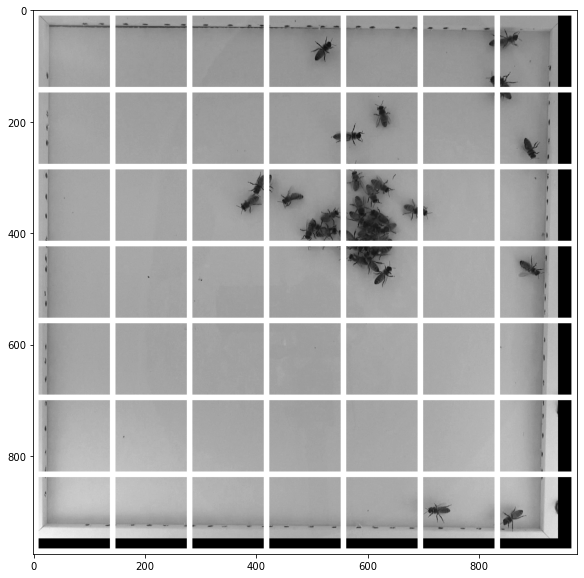

In [60]:
# Show random crops in batch
plt.figure(figsize=(14,10))
img = make_grid(x, nrow=7, normalize=True, pad_value=1, padding=10).permute(1,2,0)
plt.imshow(img);

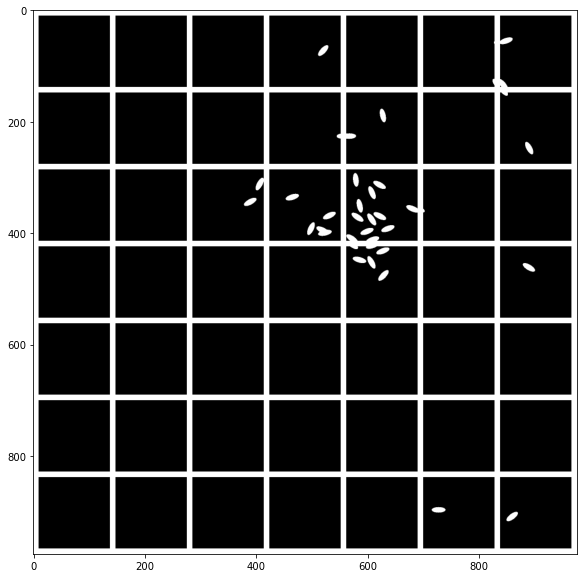

In [61]:
plt.figure(figsize=(14,10))
mask = make_grid(y.float(), nrow=7, normalize=True, pad_value=1, padding=10).permute(1,2,0)
plt.imshow(mask);

# Load class weights

In [62]:
class_weights = np.load(os.path.join(data_root, 'class_weights.npy'))
class_weights = torch.tensor(class_weights).float()

In [63]:
class_weights

tensor([0.0106, 0.9894])

# Model

In [64]:
net = model.UNet(NUM_CLASSES, upsampling='transpose').to(device)

# Optimizer and criterion

In [65]:
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [66]:
np.random.seed(SEED)
torch.manual_seed(SEED)

if CLASS_WEIGHTS:
    print('Sending class weights')
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
else:
    criterion = nn.CrossEntropyLoss()

Sending class weights


# Evaluation

In [67]:
def compute_iou(ground_truth, prediction):
    ious = []
    for i, (gt, pr) in enumerate(zip(ground_truth, prediction)):
        gt = gt.squeeze().cpu()
        pr = pr.squeeze().cpu()

        intersection = gt & pr
        union = gt | pr
        iou = (intersection.sum() / union.sum()).item()
        ious.append(iou)
    mIOU = np.mean(ious)
    return mIOU

In [68]:
def _find_main_axis(regions, region_index):
    xs, ys = np.where(regions == region_index)
    m = np.concatenate([-ys[:, np.newaxis], xs[:, np.newaxis]], axis=1)
    _, _, v = np.linalg.svd(m - np.mean(m, axis=0), full_matrices=False)
    return np.arctan2(v[0, 0], v[0, 1])

In [69]:
def find_positions(array, min_blob_size, max_blob_size):
    num_regions, regions, stats, centroids = cv2.connectedComponentsWithStats(array.astype(np.uint8))
    
    result = []
    for region_index in np.arange(1, num_regions):
        region_stats = stats[region_index]

        # Remove too big or too small blobs
        region_width, region_height = region_stats[2], region_stats[3]
        if region_width < min_blob_size or region_width > max_blob_size \
                or region_height < min_blob_size or region_height > max_blob_size:
            continue

        # Get blob properties : main axis and centroid
        ax = _find_main_axis(regions, region_index)
        x, y = centroids[region_index][0], centroids[region_index][1]

        # Find object type (biggest occurence in the region)
        ######## Need to fix the pred
        unique_values, count = np.unique(array[regions == region_index], return_counts=True)
        typ = unique_values[np.argmax(count)]

        result.append([x, y, typ, ax])

    result = np.array(result)
    return result

In [70]:
# Compute error metrics
def calculate_points_dist(preds, labels):
    # euclidean distance between pred and label
    res = np.zeros((len(preds), len(labels)))

    for ip in range(len(preds)):
        for il in range(len(labels)):
            pred = preds[ip]
            label = labels[il]
            res[ip, il] = np.sqrt((pred[0] - label[0]) ** 2 + (pred[1] - label[1]) ** 2)

    return res

In [71]:
def compute_error_metrics(result_label, result_pred, dist_min=20):
    # Find matches in dist_matrix, until no more values close to match
    TP_results = []
    correct_type = 0
    pixel_dist = []
    
    dist_matrix = calculate_points_dist(result_pred, result_label)

    while dist_matrix.shape[0] > 0 and dist_matrix.shape[1] > 0 and np.min(dist_matrix) < dist_min:
        # Find where min is iteratively, get idx for pred and for label arrays
        ip, il = np.argwhere(dist_matrix == np.min(dist_matrix))[0]

        # Assign values of pred and label arrays
        xp, yp, tp, ap = tuple(result_pred[ip])
        xl, yl, tl, al = tuple(result_label[il])

        # Count this pred as true positive
        TP_results.append(result_pred[ip])

        # Amount of pixels bw the pred and label
        pixel_dist.append(dist_matrix[ip, il])

        # Check if correct label 
        correct_type += int(tp == tl)

        # Remove the min already check, now check the next up min until hits dist_min threshold
        dist_matrix = np.delete(dist_matrix, ip, 0)
        dist_matrix = np.delete(dist_matrix, il, 1)
        result_pred = np.delete(result_pred, ip, axis=0)
        result_label = np.delete(result_label, il, axis=0)

    # The rest bestcomes false negatives and false positives
    FN_results = result_label
    FP_results = result_pred
    
    return pixel_dist, correct_type, TP_results, FN_results, FP_results

In [72]:
def tp_fp_evaluate(pred, label, min_blob_size, max_blob_size, dist_min):
    result_pred = find_positions(pred, min_blob_size, max_blob_size)
    result_label = find_positions(label, min_blob_size, max_blob_size)
    
    pixel_dist, correct_type, TP_results, FN_results, FP_results = compute_error_metrics(result_label, result_pred, dist_min=20)
    
    TP_count, FP_count, FN_count, correct_type_count = 0, 0, 0, 0
    all_pixel_dist, all_axis_diff = [], []

    TP_count += len(TP_results)
    FN_count += len(FN_results)
    FP_count += len(FP_results)
    correct_type_count += correct_type
    all_pixel_dist += pixel_dist
    
    try:
        TP_rate = TP_count / (TP_count + FN_count)
    except ZeroDivisionError:
        TP_rate = 'NA'
        
    return TP_rate

# Train loop

In [73]:
def save_model(model, optimizer, metrics, epoch_i):
    save_dict = {
        'model'   : model.state_dict(),
        'optim'   : optimizer.state_dict(),
        'metrics' : metrics,
        'epoch'   : epoch_i
    }
    save_path = os.path.join(data_root, 'model_transpose', f'segmentation_epoch{epoch_i:05}.pt')
    torch.save(save_dict, save_path)

In [74]:
metrics_path = os.path.join(data_root, f'training_metrics_transpose.pt')

In [75]:
metrics = {
        "losses" : {
            "train" : [],
            "val"  : []
        },
        "accs" : {
            "train" : [],
            "val"  : []
        },
        "mious" : {
            "train" : [],
            "val"  : []
        },
        "true_positive_rates" : {
            "train" : [],
            "val" : []
        }
    }

In [ ]:
np.random.seed(SEED)
torch.manual_seed(SEED)

try:
    highest_tpr_val = 0
    net.train()
    for epoch_i in range(NUM_EPOCHS):

        ### TRAIN
        batch_losses_train = []
        batch_accs_train = []
        batch_mious_train = []
        batch_tprs_train = []
        
        for batch_i, (x, y) in enumerate(train_loader):
            # Send x, y to gpu (or cpu)
            x = x.to(device)
            y = y.to(device)

            # Pass through model and get prediction
            y = y.long().squeeze(dim=1)
            y_pred = net(x)
            
            # Accuracy
            acc = (y_pred.argmax(dim=1) == y).float().mean().item()
            batch_accs_train.append(acc)
            
            # Mean IOU
            mIOU = compute_iou(y, y_pred.argmax(dim=1).cpu().detach().unsqueeze(dim=1))
            batch_mious_train.append(mIOU)
            
            ### Compute true positive rate on batch
            batch_tps = []
            for img_i, (label, pred) in enumerate(zip(y.unsqueeze(1), y_pred.argmax(dim=1).cpu().detach().unsqueeze(dim=1))):
                label = label.cpu().float().permute(1,2,0).detach().numpy()
                pred = pred.float().permute(1,2,0).detach().numpy()
                TP_rate = tp_fp_evaluate(pred, label, min_blob_size=min_blob_size, 
                                 max_blob_size=max_blob_size, dist_min=dist_min)
                batch_tps.append(TP_rate)
            batch_tps = [tp for tp in batch_tps if tp != 'NA'] # Remove 'NAs'
            batch_avg_tp = np.mean(batch_tps)
            batch_tprs_train.append(batch_avg_tp)

            # Compute loss
            loss = criterion(y_pred, y)
            batch_losses_train.append(float(loss.detach().item()))

            # Training step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Training progress message
            sys.stdout.write((f'\rEpoch  {epoch_i+1:4d}/{NUM_EPOCHS:4d} '
                              f'-- Batch {batch_i+1:2d}/{len(train_loader):2d} '
                              f'-- Loss: {loss:0.4f} '
                              f'-- Acc: {acc:0.4f} '
                              f'-- mIOU: {mIOU:0.4f} '
                              f'-- TPR: {batch_avg_tp:0.4f}'))
            sys.stdout.flush()

        # Save batch averages
        metrics['accs']['train'].append(np.mean(batch_accs_train))
        metrics['mious']['train'].append(np.mean(batch_mious_train))
        metrics['losses']['train'].append(np.mean(batch_losses_train))
        metrics['true_positive_rates']['train'].append(np.mean(batch_tprs_train))
        
        
        ## ----------------------------------- ##

        ### VALIDATION
        batch_losses_val = []
        batch_accs_val = []
        batch_mious_val = []
        batch_tprs_val = []
                
        with torch.no_grad():
            net.eval()
            for batch_i, (xx, yy) in enumerate(val_loader):
                # Send x, y to gpu (or cpu)
                xx = xx.to(device)
                yy = yy.to(device)

                # Pass through model and get prediction
                yy = yy.long().squeeze(dim=1)
                yy_pred = net(xx)
                
                # Accuracy
                acc_val = (yy_pred.argmax(dim=1) == yy).float().mean().item()
                batch_accs_val.append(acc_val)
                
                # Mean IOU
                mIOU_val = compute_iou(yy, yy_pred.argmax(dim=1).cpu().detach().unsqueeze(dim=1))
                batch_mious_val.append(mIOU_val)
                
                ### Compute true positive rate on batch
                batch_tps = []
                for img_i, (label, pred) in enumerate(zip(yy.unsqueeze(1), yy_pred.argmax(dim=1).cpu().detach().unsqueeze(dim=1))):
                    label = label.cpu().float().permute(1,2,0).detach().numpy()
                    pred = pred.float().permute(1,2,0).detach().numpy()
                    TP_rate = tp_fp_evaluate(pred, label, min_blob_size=min_blob_size, 
                                     max_blob_size=max_blob_size, dist_min=dist_min)
                    batch_tps.append(TP_rate)
                batch_tps = [tp for tp in batch_tps if tp != 'NA'] # Remove 'NAs'
                batch_avg_tp = np.mean(batch_tps)
                batch_tprs_val.append(batch_avg_tp)

                # Compute loss
                loss = criterion(yy_pred, yy)
                batch_losses_val.append(float(loss.detach().item()))

        # Validation progress message
        print((f'\rValidation: Epoch {epoch_i+1:4d}/{NUM_EPOCHS:4d} '
                          f'-- Loss: {np.mean(batch_losses_val):0.4f} '
                          f'-- Acc: {np.mean(batch_accs_val):0.4f} '
                          f'-- mIOU: {np.mean(batch_mious_val):0.4f} '
                          f'-- TPR: {np.mean(batch_tprs_val):0.4f}'))

        # Save batch averages
        metrics['accs']['val'].append(np.mean(batch_accs_val))
        metrics['mious']['val'].append(np.mean(batch_mious_val))
        metrics['losses']['val'].append(np.mean(batch_losses_val))
        metrics['true_positive_rates']['val'].append(np.mean(batch_tprs_val))
        
        # Save metrics
        torch.save(metrics, metrics_path)
        
        # Save model
#         if epoch_i % SAVE_FREQ == 0:
#             save_model(net, optimizer, metrics, epoch_i)
        if np.mean(batch_tprs_val) > highest_tpr_val:
            highest_tpr_val = np.mean(batch_tprs_val)
            save_model(net, optimizer, metrics, epoch_i)
            
        net.train()
        
except KeyboardInterrupt:
    print('\nEnding early.')    
    save_model(net, optimizer, metrics, epoch_i)

Validation: Epoch    1/1000 -- Loss: 0.0126 -- Acc: 0.9946 -- mIOU: nan -- TPR: 0.94077625
Validation: Epoch    2/1000 -- Loss: 0.0121 -- Acc: 0.9951 -- mIOU: nan -- TPR: 0.94238288
Validation: Epoch    3/1000 -- Loss: 0.0120 -- Acc: 0.9951 -- mIOU: nan -- TPR: 0.94258980
Validation: Epoch    4/1000 -- Loss: 0.0126 -- Acc: 0.9952 -- mIOU: nan -- TPR: 0.94859267
Validation: Epoch    5/1000 -- Loss: 0.0116 -- Acc: 0.9952 -- mIOU: nan -- TPR: 0.94540000
Validation: Epoch    6/1000 -- Loss: 0.0123 -- Acc: 0.9952 -- mIOU: nan -- TPR: 0.94528831
Validation: Epoch    7/1000 -- Loss: 0.0129 -- Acc: 0.9945 -- mIOU: nan -- TPR: 0.93088778
Validation: Epoch    8/1000 -- Loss: 0.0121 -- Acc: 0.9950 -- mIOU: nan -- TPR: 0.93957629
Validation: Epoch    9/1000 -- Loss: 0.0122 -- Acc: 0.9952 -- mIOU: nan -- TPR: 0.94919470
Validation: Epoch   10/1000 -- Loss: 0.0121 -- Acc: 0.9951 -- mIOU: nan -- TPR: 0.94429233
Validation: Epoch   11/1000 -- Loss: 0.0119 -- Acc: 0.9951 -- mIOU: nan -- TPR: 0.94118628

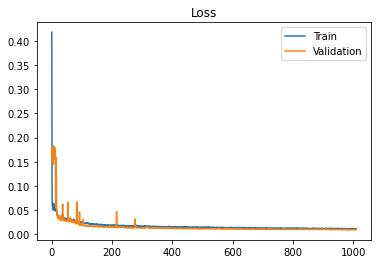

In [91]:
plt.plot(metrics['losses']['train'], label='Train')
plt.plot(metrics['losses']['val'], label='Validation')
plt.legend()
plt.title('Loss');

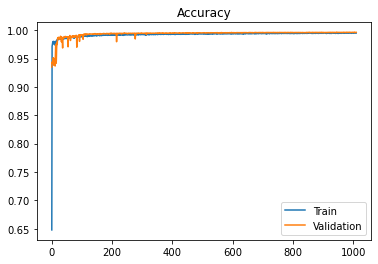

In [92]:
plt.plot(metrics['accs']['train'], label='Train')
plt.plot(metrics['accs']['val'], label='Validation')
plt.legend()
plt.title('Accuracy');

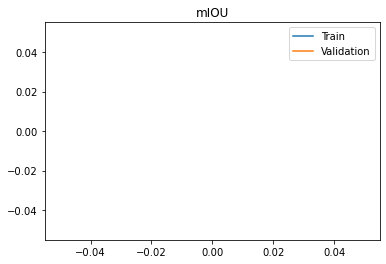

In [93]:
plt.plot(metrics['mious']['train'], label='Train')
plt.plot(metrics['mious']['val'], label='Validation')
plt.legend()
plt.title('mIOU');

In [94]:
max(metrics['true_positive_rates']['train']), max(metrics['true_positive_rates']['val'])

(0.9446304788176408, 0.9644689349759281)

In [95]:
highest_idx = np.argmax(metrics['true_positive_rates']['val'])
highest_idx, metrics['true_positive_rates']['val'][highest_idx]

(902, 0.9644689349759281)

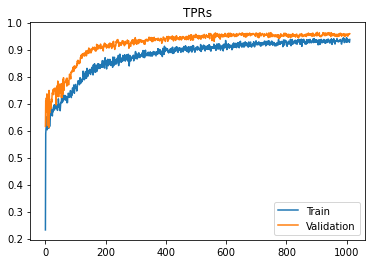

In [96]:
plt.plot(metrics['true_positive_rates']['train'], label='Train')
plt.plot(metrics['true_positive_rates']['val'], label='Validation')
plt.legend()
plt.title('TPRs');

# Test/Evaluate

### Load a saved model if wanted

In [100]:
epoch_i = 502
model_path = os.path.join(data_root, 'model_transpose', f'segmentation_epoch{epoch_i:05}.pt')

In [101]:
load_dict = torch.load(model_path)
net.load_state_dict(load_dict['model'])
optimizer.load_state_dict(load_dict['optim'])

### Visualize performance on test set

In [102]:
def make_color_pred(pred_img):
    colors = [(0, 0, 0), (255, 0, 0), (0, 255, 0)]
    color_pred = np.zeros_like(pred_img)
    for ch in range(pred_img.shape[2]):
        tmp = pred_img[:,:,0]
        color_pred[np.where(tmp==ch)] = colors[ch]
    color_pred.shape
    return color_pred

In [103]:
net.eval()
overlay_imgs = []
correct_ims = []
mIOUs = []
accs = []
tprs = []
for batch_i, (x, y) in enumerate(test_loader):
    x = x.to(device)
    y = y.to(device)
    
    with torch.no_grad():
        y_pred = net(x)
        y_pred = y_pred.argmax(dim=1)
        
        acc = (y_pred == y).float().mean()
        accs.append(acc.cpu().detach().item())
        
        y_pred = y_pred.cpu().detach().unsqueeze(dim=1)
        
        pred_img = make_grid(y_pred.float(), nrow=7, normalize=False).permute(1,2,0).detach().numpy()
        truth_img = make_grid(y.float(), nrow=7, normalize=False).permute(1,2,0).cpu().detach().numpy()
        orig = make_grid(x.float(), nrow=7, normalize=True).permute(1,2,0).cpu().detach().numpy()
        
        color_pred = make_color_pred(pred_img)
        
        overlay_img = orig.copy()
        for val in range(1, 3):
            overlay_img[pred_img==val] = color_pred[pred_img==val]
        overlay_imgs.append(overlay_img)
        
        correct_im = (pred_img == truth_img).astype(np.float)
        correct_ims.append(correct_im)
        
#         mIOU = compute_iou(y, y_pred)
#         mIOUs.append(mIOU)
        
        # For batch:
        batch_tps = []
        for img_i, (label, pred) in enumerate(zip(y, y_pred)):
            label = label.cpu().float().permute(1,2,0).detach().numpy()
            pred = pred.float().permute(1,2,0).detach().numpy()
            TP_rate = tp_fp_evaluate(pred, label, min_blob_size=min_blob_size, 
                             max_blob_size=max_blob_size, dist_min=dist_min)
            batch_tps.append(TP_rate)
        batch_tps = [tp for tp in batch_tps if tp != 'NA'] # Remove 'NAs'
        batch_avg_tp = np.mean(batch_tps)
        tprs.append(batch_avg_tp)
        
    sys.stdout.write(f'\rBatch {batch_i+1}/{len(test_loader)} '
                     f'-- Acc: {acc:0.4f} -- TPR: {batch_avg_tp}')
    sys.stdout.flush()

Batch 25/25 -- Acc: 0.9806 -- TPR: 0.7748015873015872

In [104]:
# Avg accuracy and mIOU
np.mean(accs), np.mean(mIOUs), np.mean(tprs)

(0.98095703125, nan, 0.9439199416227391)

In [111]:
# Choose a random batch to show overlay imgs
rand_i = np.random.randint(len(overlay_imgs))
rand_i

17

In [117]:
overlay_imgs[rand_i].shape

(912, 912, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


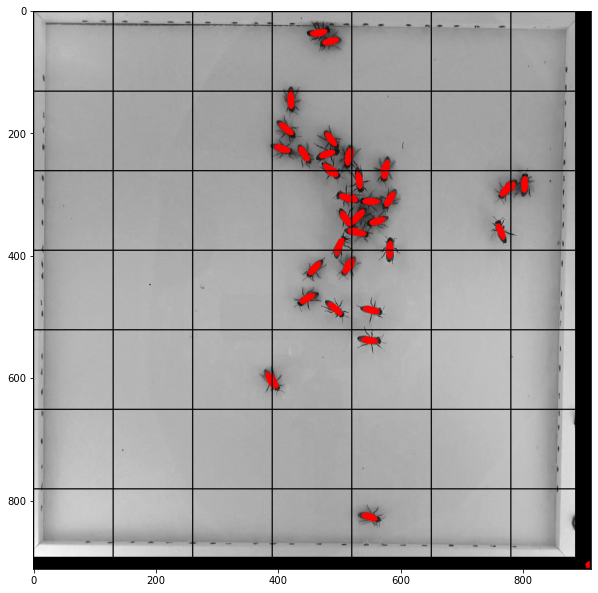

In [118]:
plt.figure(figsize=(10, 14))
plt.imshow(overlay_imgs[rand_i])

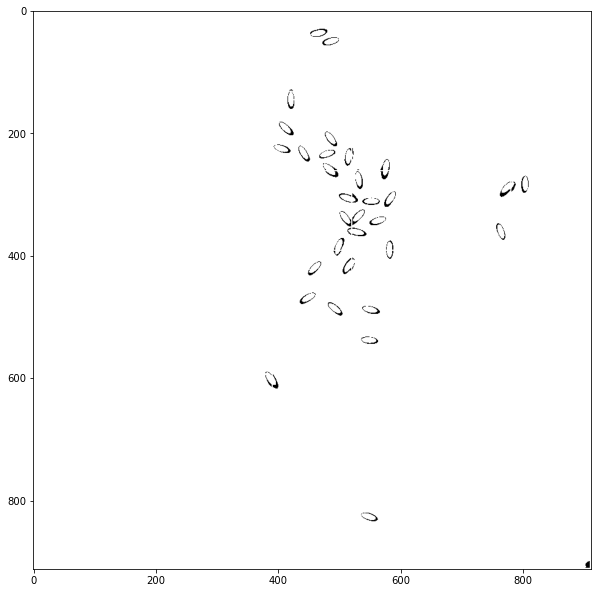

In [116]:
plt.figure(figsize=(10, 14))
plt.imshow(correct_ims[rand_i])